In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar 

In [5]:
!pip install navec

In [6]:
!pip install slovnet

In [7]:
import pandas as pd

import numpy as np
import sklearn

In [8]:
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec

from navec import Navec

In [9]:
import torch
from slovnet.model.emb import NavecEmbedding

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def clear_text(text: str):
  bad_symbols = [",", "!", ":", "/", ".", "|", "(", ")", "-", "_", "?",";"]
  clear_text = ''

  for symbol in text:
    if symbol not in bad_symbols:
      clear_text += symbol
  return clear_text

In [12]:
def add_zero_indexes(ind, max_text_ind_len):
    if len(ind) < max_text_ind_len:
        z_arr = np.zeros((max_text_ind_len - len(ind)),dtype=np.int64).T
        ind = np.concatenate((ind,z_arr),axis=0)
    return ind

In [13]:
def bin2classes(x:int):
    return np.array([0,1]) if x == 1 else np.array([1,0])
def classes2bin(x):
    return 0 if x == [1,0] else 1

In [14]:
def get_text_indexes(words: str, word_model):
    indexes = []

    for word in words:
        try:
          indexes.append(word_model.vocab[word])
        except KeyError:
          indexes.append(0)

    return np.array(indexes, dtype=np.int64)

In [15]:
model = Navec.load("navec_hudlit_v1_12B_500K_300d_100q.tar")

In [16]:
train_data = pd.read_csv("/content/train.csv")

In [17]:
test_data = pd.read_csv("/content/test.csv")

In [18]:
tokenizer = WordPunctTokenizer()

In [19]:
train_data = train_data.sort_values(by=["comment"], key=lambda x: x.str.len())

In [20]:
train_data["comment"] = train_data["comment"].apply(lambda x: tokenizer.tokenize(x.lower()))

In [21]:
#train_data["toxic"] = train_data["toxic"].apply(lambda x: bin2classes(x))

In [22]:
train_data

,id,comment,toxic
5703,5703,"[бауманка, астанавитесь]",0.0
15,15,"[после, маски, ,, лицо, жмет]",0.0
4603,4603,"[а, сколько, у, нас, шпаг, ?]",0.0
7914,7914,"[но, она, же, красивая, ...]",0.0
2713,2713,"[папич, лучший, на, трипл]",1.0
...,...,...,...
4562,4562,"[рад, ,, что, вы, допускаете, пользу, от, марк...",0.0
7904,7904,"[именно, так, ., смотрю, на, тебя, ,, стаса, ,...",1.0
11311,11311,"[агентство, darpa, в, 2020, году, планирует, н...",0.0
3335,3335,"[с, 19, апреля, в, николаеве, будет, действова...",0.0


In [23]:
train_data['indexed_text'] = train_data['comment'].apply(lambda x: get_text_indexes(x,model))

In [24]:
train_data.head()

,id,comment,toxic,indexed_text
5703,5703,"[бауманка, астанавитесь]",0.0,"[0, 0]"
15,15,"[после, маски, ,, лицо, жмет]",0.0,"[323971, 208356, 0, 198277, 124829]"
4603,4603,"[а, сколько, у, нас, шпаг, ?]",0.0,"[14251, 399941, 445396, 233124, 487958, 0]"
7914,7914,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0]"
2713,2713,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0]"


In [25]:
train_data['indexed_text_len'] = train_data['indexed_text'].apply(lambda x: len(x))

In [26]:
train_data

,id,comment,toxic,indexed_text,indexed_text_len
5703,5703,"[бауманка, астанавитесь]",0.0,"[0, 0]",2
15,15,"[после, маски, ,, лицо, жмет]",0.0,"[323971, 208356, 0, 198277, 124829]",5
4603,4603,"[а, сколько, у, нас, шпаг, ?]",0.0,"[14251, 399941, 445396, 233124, 487958, 0]",6
7914,7914,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0]",5
2713,2713,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0]",4
...,...,...,...,...,...
4562,4562,"[рад, ,, что, вы, допускаете, пользу, от, марк...",0.0,"[358905, 0, 482066, 74884, 114608, 318465, 274...",825
7904,7904,"[именно, так, ., смотрю, на, тебя, ,, стаса, ,...",1.0,"[152363, 428858, 0, 405320, 225007, 431365, 0,...",784
11311,11311,"[агентство, darpa, в, 2020, году, планирует, н...",0.0,"[16206, 3016, 51199, 0, 91885, 300229, 235924,...",716
3335,3335,"[с, 19, апреля, в, николаеве, будет, действова...",0.0,"[383451, 0, 24273, 51199, 249193, 48454, 10389...",882


In [27]:
train_data = train_data.iloc[:-20]

In [28]:
train_data

,id,comment,toxic,indexed_text,indexed_text_len
5703,5703,"[бауманка, астанавитесь]",0.0,"[0, 0]",2
15,15,"[после, маски, ,, лицо, жмет]",0.0,"[323971, 208356, 0, 198277, 124829]",5
4603,4603,"[а, сколько, у, нас, шпаг, ?]",0.0,"[14251, 399941, 445396, 233124, 487958, 0]",6
7914,7914,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0]",5
2713,2713,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0]",4
...,...,...,...,...,...
1317,1317,"[по, закону, ,, корабли, имеют, право, проходи...",0.0,"[302187, 131851, 0, 180180, 152445, 329306, 35...",420
6668,6668,"[в, любом, тоталитарном, государстве, ,, основ...",0.0,"[51199, 202150, 438428, 94789, 0, 273177, 4979...",444
9524,9524,"[доказательства, теории, относительности, можн...",0.0,"[112774, 432985, 278825, 218576, 51199, 487020...",442
10182,10182,"[вопросы, :, увидел, пару, фоток, ножей, аркос...",0.0,"[68687, 0, 446776, 287872, 466028, 250740, 255...",479


In [29]:
max_len = train_data['indexed_text_len'].max()
max_len

519

In [30]:
train_data["indexed_text"] = train_data["indexed_text"].apply(lambda x: add_zero_indexes(x, max_len))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
train_data

,id,comment,toxic,indexed_text,indexed_text_len
5703,5703,"[бауманка, астанавитесь]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
15,15,"[после, маски, ,, лицо, жмет]",0.0,"[323971, 208356, 0, 198277, 124829, 0, 0, 0, 0...",5
4603,4603,"[а, сколько, у, нас, шпаг, ?]",0.0,"[14251, 399941, 445396, 233124, 487958, 0, 0, ...",6
7914,7914,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0, 0, 0, 0, 0...",5
2713,2713,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
...,...,...,...,...,...
1317,1317,"[по, закону, ,, корабли, имеют, право, проходи...",0.0,"[302187, 131851, 0, 180180, 152445, 329306, 35...",420
6668,6668,"[в, любом, тоталитарном, государстве, ,, основ...",0.0,"[51199, 202150, 438428, 94789, 0, 273177, 4979...",444
9524,9524,"[доказательства, теории, относительности, можн...",0.0,"[112774, 432985, 278825, 218576, 51199, 487020...",442
10182,10182,"[вопросы, :, увидел, пару, фоток, ножей, аркос...",0.0,"[68687, 0, 446776, 287872, 466028, 250740, 255...",479


In [32]:
X = train_data['indexed_text'].to_list()

In [33]:
y = train_data["toxic"].to_list()

In [34]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.02, random_state=42)

In [35]:
X = []

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [37]:
class TextClassifierNN(torch.nn.Module):

    def __init__(self, embedding_dim, gru_hidden_size, fc_hidden_size, output_size, navec):
        super(TextClassifierNN, self).__init__()

        self.relu = torch.nn.ReLU()

        self.softmax = torch.nn.Softmax()

        self.dropout = torch.nn.Dropout(0.15)

        self.embedding = NavecEmbedding(navec) #torch.nn.Embedding(input_size, embedding_dim)

        self.conv1 = torch.nn.Conv1d(300, 512, kernel_size=5,padding=2)
        self.conv2 = torch.nn.Conv1d(512, 1024, kernel_size=3,padding=1)
        self.conv3 = torch.nn.Conv1d(1024, 2048, kernel_size=5,padding=2)

        self.gru = torch.nn.GRU(2048, gru_hidden_size, batch_first = True)

        self.fc1 = torch.nn.Linear(gru_hidden_size, fc_hidden_size)

        self.fc2 = torch.nn.Linear(fc_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)

        x = x.permute((0,2,1))

        x = self.conv1(x)

        x = self.relu(x)

        x = self.conv2(x)

        x = self.relu(x)

        x = self.conv3(x)

        x = self.relu(x)

        x = self.dropout(x)

        x = x.permute((0,2,1))

        x = self.gru(x)[0].mean(dim=1) # (batch_size, L, hidden_size)

        x = self.fc1(x)

        x = self.relu(x)

        x = self.fc2(x)
        
        return x

    def predict(self,x):
        return self.softmax(self.forward(x))


In [38]:
Net = TextClassifierNN(300, 512, 256, 2, model)
Net.to(device)

loss = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.from_numpy(navec.pq.indexes),


In [39]:
optimizer = torch.optim.Adam(Net.parameters(), lr=1.0e-3)

In [40]:
test_loss_history = []
test_accuracy_history = []
test_precision_history = []

In [41]:
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

X_test = torch.LongTensor(X_test)
y_test = torch.LongTensor(y_test)

In [42]:
X_test = X_test#.to(device)
y_test = y_test#.to(device)

In [43]:
Net.train()

batch_size = 100

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        with torch.no_grad():
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]#.to(device)
            y_batch = y_train[batch_indexes]#.to(device)
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

        preds = Net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
      test_preds = Net.forward(X_test.cuda()).cpu()

      loss_test_value = loss(test_preds, y_test).detach().data.cpu()

      test_loss_history.append(loss_test_value)
      
      accuracy = (test_preds.argmax(dim=1) == y_test).detach().float().mean().data.cpu()
      test_accuracy_history.append(accuracy)
      
      precision = sklearn.metrics.precision_score(test_preds.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
      test_precision_history.append(precision)

      print(f"epoch {epoch+1}; test loss {loss_test_value}; test accuracy {accuracy}; test precision {precision}")
torch.save(Net.state_dict(),"/content/drive/MyDrive/Colab Notebooks/TextClassifierNN.nn")

epoch 1; test loss 0.3206386864185333; test accuracy 0.8744588494300842; test precision 0.7125
epoch 2; test loss 0.3056889772415161; test accuracy 0.887445867061615; test precision 0.7625
epoch 3; test loss 0.25756824016571045; test accuracy 0.9090909361839294; test precision 0.85
epoch 4; test loss 0.29332926869392395; test accuracy 0.9047619104385376; test precision 0.85
epoch 5; test loss 0.2798641622066498; test accuracy 0.9090909361839294; test precision 0.9


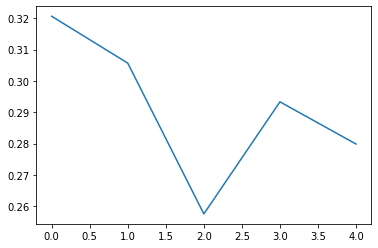

In [44]:
plt.plot(test_loss_history, label='loss')

In [1]:
plt.plot(test_accuracy_history, label='accuracy')
plt.plot(test_precision_history, label='precision')
plt.legend()
plt.show()  

NameError: ignored

In [46]:
with torch.no_grad():
    y_pred = Net.forward(X_test)

In [47]:
precision = sklearn.metrics.precision_score(y_pred.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
precision

0.9

In [48]:
recall = sklearn.metrics.recall_score(y_pred.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
recall

0.8571428571428571

In [ ]:
!nvidia-smi